In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scripts.implementations as lib  # Add personal library
import scripts.proj1_helpers as helper  # Add personal library

%matplotlib inline
%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4)

DATA_FOLDER = 'data'
DATA_TRAIN = os.path.join(DATA_FOLDER, 'train.csv')
DATA_TEST = os.path.join(DATA_FOLDER, 'test.csv')

y, x, ids, header = helper.load_csv_data(DATA_TRAIN)
y_test, x_test, ids_test, header = helper.load_csv_data(DATA_TEST)
y_train, x_train,  y_validation, x_validation = lib.sep_valid_train_data(x,y,0.2);

In [2]:
x_train[x_train == -999] = np.nan
x_test[x_test == -999] = np.nan
x_validation[x_validation == -999] = np.nan

In [3]:
tags, count = np.unique(x_train[:, 22], return_counts=True)
repart_jet = count/len(y_train)
print('Repartition of #jet {} along data {}%'.format(tags, 100*repart_jet))

Repartition of #jet [ 0.  1.  2.  3.] along data [ 39.656  31.362  20.138   8.844]%


In [4]:
for i, feature in enumerate(x_train.T):
    print('Feature {} - {} has range: [{:.4f}, {:.4f}]'.format(
        i+1, header[i], np.nanmin(feature), np.nanmax(feature)))

Feature 1 - DER_mass_MMC has range: [13.1340, 945.5550]
Feature 2 - DER_mass_transverse_met_lep has range: [0.0010, 511.4080]
Feature 3 - DER_mass_vis has range: [9.4950, 1034.2050]
Feature 4 - DER_pt_h has range: [0.0000, 762.8060]
Feature 5 - DER_deltaeta_jet_jet has range: [0.0000, 8.5030]
Feature 6 - DER_mass_jet_jet has range: [15.3190, 4974.9790]
Feature 7 - DER_prodeta_jet_jet has range: [-18.0660, 14.7000]
Feature 8 - DER_deltar_tau_lep has range: [0.3460, 5.5460]
Feature 9 - DER_pt_tot has range: [0.0000, 371.8760]
Feature 10 - DER_sum_pt has range: [46.3130, 1703.7520]
Feature 11 - DER_pt_ratio_lep_tau has range: [0.0800, 19.7730]
Feature 12 - DER_met_phi_centrality has range: [-1.4140, 1.4140]
Feature 13 - DER_lep_eta_centrality has range: [0.0000, 1.0000]
Feature 14 - PRI_tau_pt has range: [20.0000, 505.0600]
Feature 15 - PRI_tau_eta has range: [-2.4990, 2.4940]
Feature 16 - PRI_tau_phi has range: [-3.1420, 3.1420]
Feature 17 - PRI_lep_pt has range: [26.0000, 426.3980]
Feat

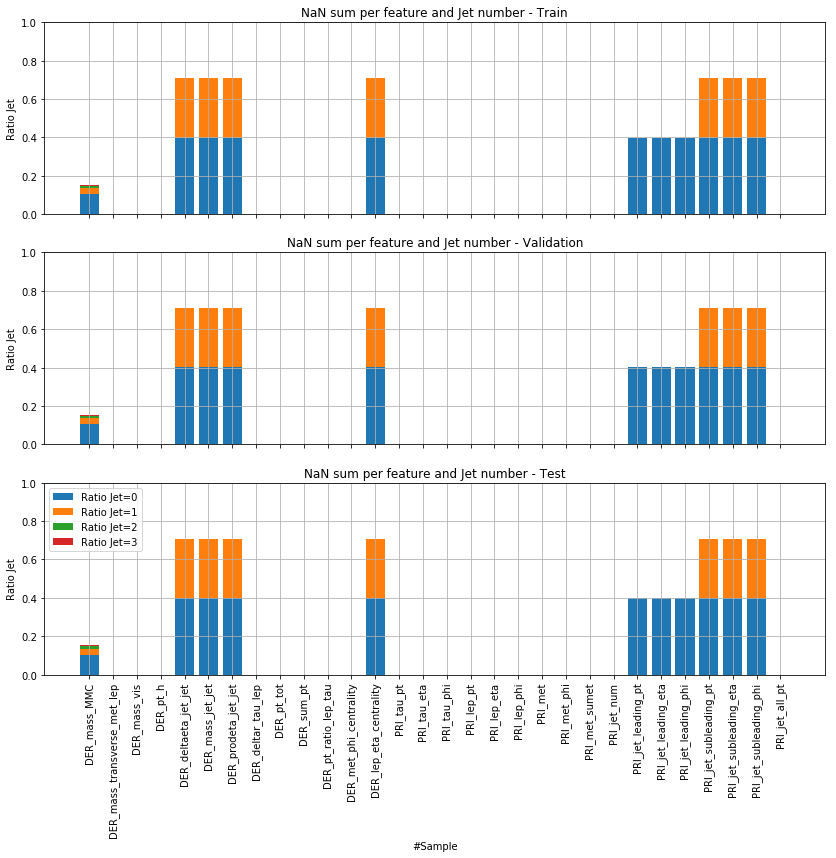

In [5]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(14, 12))
nan_j_tr = []; nan_j_val = []; nan_j_te = []
for i in range(4):
    nan_j_tr.append(np.array([ 
        np.sum(np.logical_and(x_train[:, 22] == i, np.isnan(f))) for f in x_train.T])/len(y_train))
    nan_j_val.append(np.array([
        np.sum(np.logical_and(x_validation[:, 22] == i, np.isnan(f))) for f in x_validation.T])/len(y_validation))
    nan_j_te.append(np.array([
        np.sum(np.logical_and(x_test[:, 22] == i, np.isnan(f))) for f in x_test.T])/len(y_test))
    axes[0].bar(np.arange(len(header)), nan_j_tr[-1], 
            label='Ratio Jet={}'.format(i), bottom = np.sum(np.array(nan_j_tr[:-1]), axis=0))
    axes[1].bar(np.arange(len(header)), nan_j_val[-1], 
            label='Ratio Jet={}'.format(i), bottom = np.sum(np.array(nan_j_val[:-1]), axis=0))
    axes[2].bar(np.arange(len(header)), nan_j_te[-1], 
            label='Ratio Jet={}'.format(i), bottom = np.sum(np.array(nan_j_te[:-1]), axis=0))
    
plt.xticks(np.arange(len(header)), header, rotation='vertical'); 
axes[0].set_ylim(0, 1); 
axes[0].set_ylabel('Ratio Jet'); axes[1].set_ylabel('Ratio Jet'); axes[2].set_ylabel('Ratio Jet'); 
axes[0].grid(); axes[1].grid(); axes[2].grid()
plt.xlabel('Features'); plt.xlabel('#Sample'); 
axes[0].set_title('NaN sum per feature and Jet number - Train')
axes[1].set_title('NaN sum per feature and Jet number - Validation')
axes[2].set_title('NaN sum per feature and Jet number - Test')
plt.legend(); plt.show()

In [55]:
from scripts.ml import augmented_feat_angle

def get_augmented(x, id_angle_feat=[15, 18, 20, 25, 28]):
    x_aug = augmented_feat_angle(x, id_angle_feat)
    return np.concatenate((x, x_aug), axis=1)

def get_data_jet(y, x, id_current_jet, id_jet=22):
    id_select = (x[:, id_jet] == id_current_jet)
    x_jet = x[id_select, :]
    y_jet = y[id_select]
    jet_keep = np.arange(x.shape[1]) != id_jet  # Remove jet number feature
    non_zero = np.std(x_jet, axis=0) != 0  # Remove features that have 0 std (i.e. constant)
    no_nan_keep = ~np.any(np.isnan(x_jet), axis=0)  # Remove features with nan
    return id_select, y_jet, x_jet[:, np.logical_and(np.logical_and(jet_keep, no_nan_keep), non_zero) ]
   
models = []
for i in range(4):
    _, y_train_j, x_train_j = get_data_jet(y_train, get_augmented(x_train), i)
    _, y_validation_j, x_validation_j = get_data_jet(y_validation, get_augmented(x_validation), i)
    id_test, y_test_j, x_test_j = get_data_jet(y_test, get_augmented(x_test), i)
    # Last vector is only 0's for #jet == 0, we remove it
   
    x_train_j = (x_train_j - np.mean(x_train_j, axis=0))/np.std(x_train_j, axis=0)
    x_validation_j = (x_validation_j - np.mean(x_validation_j, axis=0))/np.std(x_validation_j, axis=0)
    x_test_j = (x_test_j - np.mean(x_test_j, axis=0))/np.std(x_test_j, axis=0)
        
    models.append( {'y_train': y_train_j, 'x_train': x_train_j, 
                    'y_validation': y_validation_j, 'x_validation': x_validation_j,
                    'y_test': y_test_j, 'x_test': x_test_j, 'id_test': id_test} )
    
    print(len(models[i]['id_test']))
    

[ 3.142  3.141  3.141    nan    nan]
[-0.0025  0.0253 -0.0173 -0.0072  0.0071]
[ 3.142  3.142  3.142    nan    nan]
[-0.0096  0.0481 -0.0083 -0.0137 -0.0038]
[ 3.142  3.142  3.142    nan    nan]
[-0.0154  0.0521 -0.008  -0.0217 -0.0144]
568238
[ 3.142  3.141  3.141    nan    nan]
[-0.0025  0.0253 -0.0173 -0.0072  0.0071]
[ 3.142  3.142  3.142    nan    nan]
[-0.0096  0.0481 -0.0083 -0.0137 -0.0038]
[ 3.142  3.142  3.142    nan    nan]
[-0.0154  0.0521 -0.008  -0.0217 -0.0144]
568238
[ 3.142  3.141  3.141    nan    nan]
[-0.0025  0.0253 -0.0173 -0.0072  0.0071]
[ 3.142  3.142  3.142    nan    nan]
[-0.0096  0.0481 -0.0083 -0.0137 -0.0038]
[ 3.142  3.142  3.142    nan    nan]
[-0.0154  0.0521 -0.008  -0.0217 -0.0144]
568238
[ 3.142  3.141  3.141    nan    nan]
[-0.0025  0.0253 -0.0173 -0.0072  0.0071]
[ 3.142  3.142  3.142    nan    nan]
[-0.0096  0.0481 -0.0083 -0.0137 -0.0038]
[ 3.142  3.142  3.142    nan    nan]
[-0.0154  0.0521 -0.008  -0.0217 -0.0144]
568238


In [49]:
def plot_train_test(train_errors, test_errors, lambdas, degree):
    """
    train_errors, test_errors and lambas should be list (of the same size) the respective train error and test error for a given lambda,
    * lambda[0] = 1
    * train_errors[0] = RMSE of a ridge regression on the train set
    * test_errors[0] = RMSE of the parameter found by ridge regression applied on the test set
    
    degree is just used for the title of the plot.
    """
    plt.semilogx(lambdas, train_errors, color='b', marker='*', label="Train error")
    plt.semilogx(lambdas, test_errors, color='r', marker='*', label="Test error")
    plt.xlabel("lambda")
    plt.ylabel("RMSE")
    plt.title("Ridge regression for polynomial degree " + str(degree))
    leg = plt.legend(loc=1, shadow=True)
    leg.draw_frame(False)
    plt.savefig("ridge_regression")
    
def test_ridge_regression(x, y, x_val, y_val, degrees, lambdas):
    
    best_acc = 0
    best_degree = 0
    best_lambda = 0
    best_rmse_tr = []
    best_rmse_te = []
    best_weights = []
    for degree in degrees:
        degree = int(degree)
        #lambdas = np.logspace(-7, 2, 20)

        # Split sets
        #x_train, x_test, y_train, y_test = split_data(x, y, ratio, seed)

        # Get ploynomial
        phi_train = lib.build_poly(x, degree)
        phi_test = lib.build_poly(x_val, degree)

        rmse_tr = []
        rmse_te = []
        update_rmse = False

        for ind, lambda_ in enumerate(lambdas):

            mse_tr, weights = lib.ridge_regression(y, phi_train, lambda_)
            mse_te = lib.compute_loss(y_val, phi_test.dot(weights))
            rmse_tr.append(np.sqrt(2*mse_tr))
            rmse_te.append(np.sqrt(2*mse_te))

            print("degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
                    d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
            print('train acc : ', lib.accuracy(y, phi_train.dot(weights)))
            val_acc = lib.accuracy(y_val, phi_test.dot(weights))
            print('validation acc : ', val_acc)

            if(val_acc > best_acc):
                best_acc = val_acc
                best_degree = degree
                best_lambda = lambda_
                best_weights = weights
                update_rmse = True
        
        if(update_rmse):
            best_rmse_tr = rmse_tr
            best_rmse_te = rmse_te

        # Plot the best obtained results
    plot_train_test(best_rmse_tr, best_rmse_te, lambdas, best_degree)

    print('Best params for Ridge regression : degree = ',best_degree, ', lambda = ',best_lambda,', accuracy = ', best_acc)
    
    return best_weights, best_degree, best_lambda

************ Model 1 ************* 
degree=1, lambda=0.000, Training RMSE=0.738, Testing RMSE=0.738
train acc :  0.814807343151
validation acc :  0.818405444216
degree=1, lambda=0.000, Training RMSE=0.738, Testing RMSE=0.738
train acc :  0.814807343151
validation acc :  0.818392957483
degree=1, lambda=0.000, Training RMSE=0.738, Testing RMSE=0.738
train acc :  0.814807343151
validation acc :  0.818355497284
degree=1, lambda=0.000, Training RMSE=0.738, Testing RMSE=0.738
train acc :  0.814807343151
validation acc :  0.818367984017
degree=1, lambda=0.000, Training RMSE=0.738, Testing RMSE=0.738
train acc :  0.814807343151
validation acc :  0.818367984017
degree=1, lambda=0.000, Training RMSE=0.738, Testing RMSE=0.738
train acc :  0.814807343151
validation acc :  0.818367984017
degree=1, lambda=0.000, Training RMSE=0.738, Testing RMSE=0.738
train acc :  0.814807343151
validation acc :  0.818367984017
degree=1, lambda=0.000, Training RMSE=0.738, Testing RMSE=0.738
train acc :  0.8148073431

validation acc :  0.745183242805
degree=2, lambda=0.023, Training RMSE=0.920, Testing RMSE=1.641
train acc :  0.742838410329
validation acc :  0.745358057064
degree=2, lambda=0.031, Training RMSE=0.945, Testing RMSE=1.349
train acc :  0.742838410329
validation acc :  0.745358057064
degree=2, lambda=0.041, Training RMSE=0.965, Testing RMSE=1.151
train acc :  0.742838410329
validation acc :  0.745358057064
degree=2, lambda=0.055, Training RMSE=0.978, Testing RMSE=1.052
train acc :  0.742838410329
validation acc :  0.745358057064
degree=2, lambda=0.074, Training RMSE=0.987, Testing RMSE=1.014
train acc :  0.742838410329
validation acc :  0.745358057064
degree=2, lambda=0.100, Training RMSE=0.992, Testing RMSE=1.002
train acc :  0.742838410329
validation acc :  0.745358057064
degree=3, lambda=0.000, Training RMSE=0.702, Testing RMSE=7.910
train acc :  0.826054064959
validation acc :  0.830717362802
degree=3, lambda=0.000, Training RMSE=0.702, Testing RMSE=7.904
train acc :  0.826054064959


degree=4, lambda=0.002, Training RMSE=0.708, Testing RMSE=782.296
train acc :  0.824994956627
validation acc :  0.825959917588
degree=4, lambda=0.002, Training RMSE=0.713, Testing RMSE=230.048
train acc :  0.823179342344
validation acc :  0.822975588437
degree=4, lambda=0.003, Training RMSE=0.722, Testing RMSE=638.945
train acc :  0.817228162195
validation acc :  0.819104701255
degree=4, lambda=0.004, Training RMSE=0.735, Testing RMSE=1620.848
train acc :  0.810066572524
validation acc :  0.811700068677
degree=4, lambda=0.005, Training RMSE=0.752, Testing RMSE=2444.788
train acc :  0.797861609845
validation acc :  0.801848036461
degree=4, lambda=0.007, Training RMSE=0.772, Testing RMSE=2896.273
train acc :  0.783891466613
validation acc :  0.787450833489
degree=4, lambda=0.009, Training RMSE=0.793, Testing RMSE=2894.754
train acc :  0.772392576155
validation acc :  0.773790347756
degree=4, lambda=0.013, Training RMSE=0.813, Testing RMSE=2493.705
train acc :  0.763617107121
validation a

degree=6, lambda=0.000, Training RMSE=0.690, Testing RMSE=27940605.330
train acc :  0.837603389147
validation acc :  0.838858712618
degree=6, lambda=0.000, Training RMSE=0.690, Testing RMSE=27821893.857
train acc :  0.837300786766
validation acc :  0.838683898358
degree=6, lambda=0.000, Training RMSE=0.690, Testing RMSE=27631602.162
train acc :  0.837099051846
validation acc :  0.838746332022
degree=6, lambda=0.000, Training RMSE=0.690, Testing RMSE=27331853.844
train acc :  0.836998184386
validation acc :  0.838658924892
degree=6, lambda=0.000, Training RMSE=0.690, Testing RMSE=26870782.464
train acc :  0.837099051846
validation acc :  0.838746332022
degree=6, lambda=0.000, Training RMSE=0.690, Testing RMSE=26167192.306
train acc :  0.836846883195
validation acc :  0.838683898358
degree=6, lambda=0.000, Training RMSE=0.690, Testing RMSE=25078055.557
train acc :  0.836897316926
validation acc :  0.838883686084
degree=6, lambda=0.000, Training RMSE=0.690, Testing RMSE=23365413.154
train

degree=7, lambda=0.041, Training RMSE=0.857, Testing RMSE=498704861.252
train acc :  0.760742384507
validation acc :  0.760729225198
degree=7, lambda=0.055, Training RMSE=0.880, Testing RMSE=414381641.819
train acc :  0.758018963083
validation acc :  0.757769869514
degree=7, lambda=0.074, Training RMSE=0.903, Testing RMSE=272911193.347
train acc :  0.755295541658
validation acc :  0.755534744334
degree=7, lambda=0.100, Training RMSE=0.924, Testing RMSE=118376236.554
train acc :  0.74974783135
validation acc :  0.752875070238
degree=8, lambda=0.000, Training RMSE=0.686, Testing RMSE=117175668652.612
train acc :  0.842041557394
validation acc :  0.52015983018
degree=8, lambda=0.000, Training RMSE=0.687, Testing RMSE=117199757002.215
train acc :  0.841991123664
validation acc :  0.499132172067
degree=8, lambda=0.000, Training RMSE=0.687, Testing RMSE=117204156901.204
train acc :  0.842495460964
validation acc :  0.494000124867
degree=8, lambda=0.000, Training RMSE=0.684, Testing RMSE=1172

degree=9, lambda=0.000, Training RMSE=0.742, Testing RMSE=20387055057698.992
train acc :  0.842293726044
validation acc :  0.838234375976
degree=9, lambda=0.000, Training RMSE=0.683, Testing RMSE=17878078870485.469
train acc :  0.842041557394
validation acc :  0.834388462259
degree=9, lambda=0.000, Training RMSE=0.683, Testing RMSE=14713171199917.248
train acc :  0.841738955013
validation acc :  0.840631828682
degree=9, lambda=0.000, Training RMSE=0.684, Testing RMSE=11194322444775.322
train acc :  0.841335485172
validation acc :  0.827920334644
degree=9, lambda=0.000, Training RMSE=0.685, Testing RMSE=7817140583347.131
train acc :  0.83997377446
validation acc :  0.829256415059
degree=9, lambda=0.001, Training RMSE=0.688, Testing RMSE=5082862135786.403
train acc :  0.837653822877
validation acc :  0.836099144659
degree=9, lambda=0.001, Training RMSE=0.691, Testing RMSE=3333431081684.859
train acc :  0.834577365342
validation acc :  0.8358868702
degree=9, lambda=0.001, Training RMSE=0.

degree=10, lambda=0.041, Training RMSE=0.814, Testing RMSE=57736322929270.102
train acc :  0.771787371394
validation acc :  0.773628020229
degree=10, lambda=0.055, Training RMSE=0.831, Testing RMSE=9235662334775.994
train acc :  0.767197901957
validation acc :  0.767971530249
degree=10, lambda=0.074, Training RMSE=0.846, Testing RMSE=25957943837365.672
train acc :  0.764524914263
validation acc :  0.764462758319
degree=10, lambda=0.100, Training RMSE=0.860, Testing RMSE=46486438923308.766
train acc :  0.758220698003
validation acc :  0.757919710308
degree=11, lambda=0.000, Training RMSE=73.331, Testing RMSE=51592522720076640.000
train acc :  0.545239055881
validation acc :  0.489367546981
degree=11, lambda=0.000, Training RMSE=40.918, Testing RMSE=74898155519687008.000
train acc :  0.545592091991
validation acc :  0.480352125866
degree=11, lambda=0.000, Training RMSE=33.381, Testing RMSE=80268243305756928.000
train acc :  0.553106717773
validation acc :  0.531460323406
degree=11, lambd

validation acc :  0.709212291677
degree=1, lambda=0.003, Training RMSE=0.883, Testing RMSE=0.886
train acc :  0.712390791404
validation acc :  0.7088405024
degree=1, lambda=0.004, Training RMSE=0.897, Testing RMSE=0.899
train acc :  0.708819590587
validation acc :  0.70601167095
degree=1, lambda=0.005, Training RMSE=0.915, Testing RMSE=0.916
train acc :  0.706460047191
validation acc :  0.704007241809
degree=1, lambda=0.007, Training RMSE=0.935, Testing RMSE=0.935
train acc :  0.701804731841
validation acc :  0.701970483164
degree=1, lambda=0.009, Training RMSE=0.954, Testing RMSE=0.954
train acc :  0.700401760092
validation acc :  0.700014548276
degree=1, lambda=0.013, Training RMSE=0.969, Testing RMSE=0.969
train acc :  0.698424845354
validation acc :  0.698495061669
degree=1, lambda=0.017, Training RMSE=0.981, Testing RMSE=0.981
train acc :  0.696001530515
validation acc :  0.696264326011
degree=1, lambda=0.023, Training RMSE=0.989, Testing RMSE=0.989
train acc :  0.695236273197
val

degree=3, lambda=0.000, Training RMSE=0.810, Testing RMSE=0.841
train acc :  0.771315604872
validation acc :  0.759306855471
degree=3, lambda=0.000, Training RMSE=0.811, Testing RMSE=0.842
train acc :  0.770805433327
validation acc :  0.759258361218
degree=3, lambda=0.001, Training RMSE=0.811, Testing RMSE=0.843
train acc :  0.771188061986
validation acc :  0.759403843978
degree=3, lambda=0.001, Training RMSE=0.812, Testing RMSE=0.844
train acc :  0.76965754735
validation acc :  0.759484667734
degree=3, lambda=0.001, Training RMSE=0.813, Testing RMSE=0.845
train acc :  0.769338690135
validation acc :  0.75914520796
degree=3, lambda=0.002, Training RMSE=0.816, Testing RMSE=0.845
train acc :  0.767808175499
validation acc :  0.759420008729
degree=3, lambda=0.002, Training RMSE=0.820, Testing RMSE=0.845
train acc :  0.766915375295
validation acc :  0.758611771172
degree=3, lambda=0.003, Training RMSE=0.826, Testing RMSE=0.848
train acc :  0.76296154582
validation acc :  0.757156943569
deg

validation acc :  0.758999725199
degree=5, lambda=0.000, Training RMSE=0.799, Testing RMSE=0.973
train acc :  0.777628977744
validation acc :  0.769555307696
degree=5, lambda=0.000, Training RMSE=0.799, Testing RMSE=0.973
train acc :  0.77775652063
validation acc :  0.769264342175
degree=5, lambda=0.000, Training RMSE=0.799, Testing RMSE=0.972
train acc :  0.77794783496
validation acc :  0.769232012673
degree=5, lambda=0.000, Training RMSE=0.799, Testing RMSE=0.971
train acc :  0.778011606403
validation acc :  0.769425989687
degree=5, lambda=0.000, Training RMSE=0.799, Testing RMSE=0.969
train acc :  0.778011606403
validation acc :  0.769361330682
degree=5, lambda=0.000, Training RMSE=0.799, Testing RMSE=0.967
train acc :  0.77794783496
validation acc :  0.769490648691
degree=5, lambda=0.000, Training RMSE=0.799, Testing RMSE=0.964
train acc :  0.778139149289
validation acc :  0.769991755977
degree=5, lambda=0.000, Training RMSE=0.800, Testing RMSE=0.960
train acc :  0.778458006505
val

degree=6, lambda=0.055, Training RMSE=0.927, Testing RMSE=1.571
train acc :  0.668005866973
validation acc :  0.663870164719
degree=6, lambda=0.074, Training RMSE=0.939, Testing RMSE=1.289
train acc :  0.665391237804
validation acc :  0.662011218337
degree=6, lambda=0.100, Training RMSE=0.952, Testing RMSE=1.059
train acc :  0.664115808941
validation acc :  0.659731988426
degree=7, lambda=0.000, Training RMSE=6.633, Testing RMSE=1799.000
train acc :  0.480581595562
validation acc :  0.517207377592
degree=7, lambda=0.000, Training RMSE=3.045, Testing RMSE=2222.497
train acc :  0.493973598623
validation acc :  0.492798603366
degree=7, lambda=0.000, Training RMSE=6.215, Testing RMSE=1577.599
train acc :  0.579299789554
validation acc :  0.541551492815
degree=7, lambda=0.000, Training RMSE=6.656, Testing RMSE=379.515
train acc :  0.602703909189
validation acc :  0.502562113056
degree=7, lambda=0.000, Training RMSE=3.460, Testing RMSE=177.113
train acc :  0.563038071552
validation acc :  0.

degree=8, lambda=0.001, Training RMSE=5.761, Testing RMSE=135.099
train acc :  0.399273005548
validation acc :  0.578633431938
degree=8, lambda=0.001, Training RMSE=2.923, Testing RMSE=69.762
train acc :  0.439449014731
validation acc :  0.436626093141
degree=8, lambda=0.001, Training RMSE=1.750, Testing RMSE=38.486
train acc :  0.516484918054
validation acc :  0.513133860304
degree=8, lambda=0.002, Training RMSE=0.896, Testing RMSE=13.497
train acc :  0.712071934188
validation acc :  0.710586295524
degree=8, lambda=0.002, Training RMSE=0.981, Testing RMSE=24.393
train acc :  0.71028633378
validation acc :  0.709228456428
degree=8, lambda=0.003, Training RMSE=0.830, Testing RMSE=39.834
train acc :  0.74676359926
validation acc :  0.741816594734
degree=8, lambda=0.004, Training RMSE=0.827, Testing RMSE=47.144
train acc :  0.756648172948
validation acc :  0.747668234648
degree=8, lambda=0.005, Training RMSE=0.834, Testing RMSE=46.298
train acc :  0.756903258721
validation acc :  0.747926

degree=10, lambda=0.000, Training RMSE=27.268, Testing RMSE=4804.683
train acc :  0.384605573624
validation acc :  0.465431679679
degree=10, lambda=0.000, Training RMSE=18.068, Testing RMSE=2944.277
train acc :  0.55226069766
validation acc :  0.531755653622
degree=10, lambda=0.000, Training RMSE=11.932, Testing RMSE=2787.538
train acc :  0.499968114278
validation acc :  0.450155989849
degree=10, lambda=0.000, Training RMSE=23.686, Testing RMSE=2233.268
train acc :  0.619284484408
validation acc :  0.568659780483
degree=10, lambda=0.000, Training RMSE=50.913, Testing RMSE=2846.838
train acc :  0.40195140616
validation acc :  0.582529136964
degree=10, lambda=0.000, Training RMSE=12.284, Testing RMSE=3132.721
train acc :  0.46980422167
validation acc :  0.410956468325
degree=10, lambda=0.000, Training RMSE=28.146, Testing RMSE=1758.888
train acc :  0.559530642178
validation acc :  0.472172380906
degree=10, lambda=0.000, Training RMSE=11.808, Testing RMSE=2251.672
train acc :  0.494930170

degree=11, lambda=0.013, Training RMSE=5.160, Testing RMSE=1288.635
train acc :  0.461067533958
validation acc :  0.463330262031
degree=11, lambda=0.017, Training RMSE=4.451, Testing RMSE=2103.001
train acc :  0.524328805561
validation acc :  0.526696086514
degree=11, lambda=0.023, Training RMSE=6.841, Testing RMSE=2535.072
train acc :  0.61163191123
validation acc :  0.61144787676
degree=11, lambda=0.031, Training RMSE=7.885, Testing RMSE=2586.522
train acc :  0.468082392705
validation acc :  0.470167951764
degree=11, lambda=0.041, Training RMSE=5.323, Testing RMSE=2291.835
train acc :  0.433071870416
validation acc :  0.436335127621
degree=11, lambda=0.055, Training RMSE=4.377, Testing RMSE=1734.192
train acc :  0.414131751802
validation acc :  0.410212889773
degree=11, lambda=0.074, Training RMSE=6.699, Testing RMSE=1052.173
train acc :  0.412983865825
validation acc :  0.414545043079
degree=11, lambda=0.100, Training RMSE=9.731, Testing RMSE=395.479
train acc :  0.422422039411
vali

degree=2, lambda=0.009, Training RMSE=0.881, Testing RMSE=0.884
train acc :  0.739398152746
validation acc :  0.737707764823
degree=2, lambda=0.013, Training RMSE=0.904, Testing RMSE=0.906
train acc :  0.7336378985
validation acc :  0.736045646242
degree=2, lambda=0.017, Training RMSE=0.927, Testing RMSE=0.927
train acc :  0.733737213229
validation acc :  0.73406102704
degree=2, lambda=0.023, Training RMSE=0.946, Testing RMSE=0.947
train acc :  0.730956400834
validation acc :  0.73287025552
degree=2, lambda=0.031, Training RMSE=0.963, Testing RMSE=0.963
train acc :  0.726487238057
validation acc :  0.731704291739
degree=2, lambda=0.041, Training RMSE=0.976, Testing RMSE=0.976
train acc :  0.724699572947
validation acc :  0.728231208137
degree=2, lambda=0.055, Training RMSE=0.985, Testing RMSE=0.985
train acc :  0.722415334194
validation acc :  0.726742743736
degree=2, lambda=0.074, Training RMSE=0.991, Testing RMSE=0.991
train acc :  0.721024927997
validation acc :  0.724237161995
degr

degree=4, lambda=0.000, Training RMSE=0.777, Testing RMSE=1.044
train acc :  0.799086304499
validation acc :  0.786827090052
degree=4, lambda=0.000, Training RMSE=0.777, Testing RMSE=1.046
train acc :  0.799682192869
validation acc :  0.786504589432
degree=4, lambda=0.000, Training RMSE=0.777, Testing RMSE=1.049
train acc :  0.799682192869
validation acc :  0.786777474572
degree=4, lambda=0.000, Training RMSE=0.777, Testing RMSE=1.051
train acc :  0.799384248684
validation acc :  0.786851897792
degree=4, lambda=0.001, Training RMSE=0.777, Testing RMSE=1.048
train acc :  0.79779521303
validation acc :  0.787521706773
degree=4, lambda=0.001, Training RMSE=0.778, Testing RMSE=1.038
train acc :  0.797695898302
validation acc :  0.787744976433
degree=4, lambda=0.001, Training RMSE=0.780, Testing RMSE=1.016
train acc :  0.797000695203
validation acc :  0.786579012652
degree=4, lambda=0.002, Training RMSE=0.783, Testing RMSE=0.988
train acc :  0.795610289006
validation acc :  0.784991317291
d

degree=6, lambda=0.000, Training RMSE=0.766, Testing RMSE=10.497
train acc :  0.801767802165
validation acc :  0.778690151327
degree=6, lambda=0.000, Training RMSE=0.766, Testing RMSE=10.485
train acc :  0.80206574635
validation acc :  0.785164971471
degree=6, lambda=0.000, Training RMSE=0.766, Testing RMSE=10.476
train acc :  0.801072599066
validation acc :  0.789084594393
degree=6, lambda=0.000, Training RMSE=0.766, Testing RMSE=10.469
train acc :  0.80087396961
validation acc :  0.789804018854
degree=6, lambda=0.000, Training RMSE=0.766, Testing RMSE=10.463
train acc :  0.800774654881
validation acc :  0.790424212354
degree=6, lambda=0.000, Training RMSE=0.766, Testing RMSE=10.456
train acc :  0.800774654881
validation acc :  0.790052096254
degree=6, lambda=0.000, Training RMSE=0.766, Testing RMSE=10.445
train acc :  0.800973284338
validation acc :  0.789630364674
degree=6, lambda=0.000, Training RMSE=0.766, Testing RMSE=10.428
train acc :  0.800774654881
validation acc :  0.7897295

degree=7, lambda=0.013, Training RMSE=0.851, Testing RMSE=118.591
train acc :  0.746350183732
validation acc :  0.735003721161
degree=7, lambda=0.017, Training RMSE=0.863, Testing RMSE=78.926
train acc :  0.737213228722
validation acc :  0.727139667576
degree=7, lambda=0.023, Training RMSE=0.876, Testing RMSE=37.611
train acc :  0.727182441156
validation acc :  0.720590424212
degree=7, lambda=0.031, Training RMSE=0.889, Testing RMSE=16.027
train acc :  0.720329724898
validation acc :  0.715777722649
degree=7, lambda=0.041, Training RMSE=0.902, Testing RMSE=36.339
train acc :  0.719932465985
validation acc :  0.710716943686
degree=7, lambda=0.055, Training RMSE=0.914, Testing RMSE=52.325
train acc :  0.71595987685
validation acc :  0.706524435624
degree=7, lambda=0.074, Training RMSE=0.924, Testing RMSE=58.444
train acc :  0.714867414838
validation acc :  0.703572314562
degree=7, lambda=0.100, Training RMSE=0.933, Testing RMSE=56.089
train acc :  0.713079749727
validation acc :  0.70421

degree=9, lambda=0.000, Training RMSE=0.741, Testing RMSE=5117.909
train acc :  0.822524580395
validation acc :  0.788588439593
degree=9, lambda=0.000, Training RMSE=0.742, Testing RMSE=4998.335
train acc :  0.82222663621
validation acc :  0.802331927561
degree=9, lambda=0.000, Training RMSE=0.742, Testing RMSE=4901.929
train acc :  0.822127321482
validation acc :  0.802704043662
degree=9, lambda=0.000, Training RMSE=0.743, Testing RMSE=4881.802
train acc :  0.821829377297
validation acc :  0.803398660382
degree=9, lambda=0.000, Training RMSE=0.744, Testing RMSE=4993.091
train acc :  0.821928692025
validation acc :  0.803572314562
degree=9, lambda=0.001, Training RMSE=0.746, Testing RMSE=5241.416
train acc :  0.819545138544
validation acc :  0.802778466882
degree=9, lambda=0.001, Training RMSE=0.749, Testing RMSE=5501.122
train acc :  0.817757473433
validation acc :  0.80017365418
degree=9, lambda=0.001, Training RMSE=0.754, Testing RMSE=5460.926
train acc :  0.8130896812
validation ac

validation acc :  0.495013644257
degree=11, lambda=0.000, Training RMSE=1.443, Testing RMSE=711767.780
train acc :  0.621908829079
validation acc :  0.497147109898
degree=11, lambda=0.000, Training RMSE=2.095, Testing RMSE=712745.208
train acc :  0.569768596683
validation acc :  0.505135202183
degree=11, lambda=0.000, Training RMSE=1.855, Testing RMSE=715225.846
train acc :  0.599761644652
validation acc :  0.502356735301
degree=11, lambda=0.000, Training RMSE=2.203, Testing RMSE=718007.776
train acc :  0.488628463601
validation acc :  0.494319027537
degree=11, lambda=0.000, Training RMSE=3.758, Testing RMSE=721378.229
train acc :  0.576919257126
validation acc :  0.502307119821
degree=11, lambda=0.000, Training RMSE=1.402, Testing RMSE=725023.677
train acc :  0.607011619823
validation acc :  0.488836516993
degree=11, lambda=0.000, Training RMSE=1.732, Testing RMSE=728016.418
train acc :  0.664812791737
validation acc :  0.480327462168
degree=11, lambda=0.000, Training RMSE=2.832, Test

validation acc :  0.729906436704
degree=2, lambda=0.000, Training RMSE=0.815, Testing RMSE=0.849
train acc :  0.762550881954
validation acc :  0.734190057491
degree=2, lambda=0.000, Training RMSE=0.815, Testing RMSE=0.839
train acc :  0.762777023971
validation acc :  0.739882764063
degree=2, lambda=0.000, Training RMSE=0.815, Testing RMSE=0.832
train acc :  0.762550881954
validation acc :  0.745631834066
degree=2, lambda=0.000, Training RMSE=0.815, Testing RMSE=0.828
train acc :  0.762098597919
validation acc :  0.748562732499
degree=2, lambda=0.000, Training RMSE=0.815, Testing RMSE=0.826
train acc :  0.762098597919
validation acc :  0.749295457107
degree=2, lambda=0.000, Training RMSE=0.815, Testing RMSE=0.825
train acc :  0.762098597919
validation acc :  0.751099086912
degree=2, lambda=0.000, Training RMSE=0.815, Testing RMSE=0.825
train acc :  0.762098597919
validation acc :  0.751606357795
degree=2, lambda=0.000, Training RMSE=0.815, Testing RMSE=0.825
train acc :  0.762098597919


degree=4, lambda=0.000, Training RMSE=0.782, Testing RMSE=2.342
train acc :  0.792175486205
validation acc :  0.586292413482
degree=4, lambda=0.000, Training RMSE=0.782, Testing RMSE=2.253
train acc :  0.792853912257
validation acc :  0.594465111036
degree=4, lambda=0.000, Training RMSE=0.782, Testing RMSE=2.141
train acc :  0.79262777024
validation acc :  0.609570510653
degree=4, lambda=0.000, Training RMSE=0.782, Testing RMSE=2.026
train acc :  0.792401628223
validation acc :  0.636512230865
degree=4, lambda=0.000, Training RMSE=0.783, Testing RMSE=1.932
train acc :  0.79262777024
validation acc :  0.669259384511
degree=4, lambda=0.000, Training RMSE=0.783, Testing RMSE=1.874
train acc :  0.791949344188
validation acc :  0.711531958066
degree=4, lambda=0.000, Training RMSE=0.783, Testing RMSE=1.847
train acc :  0.791723202171
validation acc :  0.750535452598
degree=4, lambda=0.000, Training RMSE=0.783, Testing RMSE=1.836
train acc :  0.790592492085
validation acc :  0.770600834179
de

degree=5, lambda=0.013, Training RMSE=0.836, Testing RMSE=2.081
train acc :  0.739936680235
validation acc :  0.732780971706
degree=5, lambda=0.017, Training RMSE=0.846, Testing RMSE=2.451
train acc :  0.732926277702
validation acc :  0.728328260625
degree=5, lambda=0.023, Training RMSE=0.856, Testing RMSE=2.895
train acc :  0.72591587517
validation acc :  0.724101003269
degree=5, lambda=0.031, Training RMSE=0.866, Testing RMSE=3.266
train acc :  0.722071460877
validation acc :  0.719761019051
degree=5, lambda=0.041, Training RMSE=0.877, Testing RMSE=3.517
train acc :  0.715061058345
validation acc :  0.715759215421
degree=5, lambda=0.055, Training RMSE=0.889, Testing RMSE=3.625
train acc :  0.712799638173
validation acc :  0.714350129636
degree=5, lambda=0.074, Training RMSE=0.903, Testing RMSE=3.548
train acc :  0.712347354138
validation acc :  0.712321046105
degree=5, lambda=0.100, Training RMSE=0.918, Testing RMSE=3.259
train acc :  0.710312075984
validation acc :  0.711362867771
d

degree=7, lambda=0.000, Training RMSE=0.763, Testing RMSE=739.292
train acc :  0.80144730891
validation acc :  0.782098974186
degree=7, lambda=0.000, Training RMSE=0.764, Testing RMSE=721.501
train acc :  0.800316598824
validation acc :  0.781422613009
degree=7, lambda=0.001, Training RMSE=0.765, Testing RMSE=692.112
train acc :  0.79986431479
validation acc :  0.781817157029
degree=7, lambda=0.001, Training RMSE=0.766, Testing RMSE=645.118
train acc :  0.798733604704
validation acc :  0.7806898884
degree=7, lambda=0.001, Training RMSE=0.768, Testing RMSE=574.270
train acc :  0.798055178652
validation acc :  0.779675346635
degree=7, lambda=0.002, Training RMSE=0.771, Testing RMSE=476.070
train acc :  0.79579375848
validation acc :  0.779168075752
degree=7, lambda=0.002, Training RMSE=0.775, Testing RMSE=353.942
train acc :  0.791723202171
validation acc :  0.776518994476
degree=7, lambda=0.003, Training RMSE=0.781, Testing RMSE=221.426
train acc :  0.784260515604
validation acc :  0.77

degree=9, lambda=0.000, Training RMSE=0.744, Testing RMSE=23026.202
train acc :  0.814563545907
validation acc :  0.514316311577
degree=9, lambda=0.000, Training RMSE=0.744, Testing RMSE=23039.674
train acc :  0.815015829941
validation acc :  0.545992560027
degree=9, lambda=0.000, Training RMSE=0.744, Testing RMSE=23056.395
train acc :  0.81592039801
validation acc :  0.596268740841
degree=9, lambda=0.000, Training RMSE=0.744, Testing RMSE=23073.688
train acc :  0.815694255993
validation acc :  0.65195581107
degree=9, lambda=0.000, Training RMSE=0.744, Testing RMSE=23085.612
train acc :  0.815468113976
validation acc :  0.638879494984
degree=9, lambda=0.000, Training RMSE=0.745, Testing RMSE=23084.447
train acc :  0.815241971958
validation acc :  0.712997407282
degree=9, lambda=0.000, Training RMSE=0.745, Testing RMSE=23063.113
train acc :  0.814789687924
validation acc :  0.762202682899
degree=9, lambda=0.000, Training RMSE=0.745, Testing RMSE=23016.310
train acc :  0.814563545907
val

degree=10, lambda=0.009, Training RMSE=0.810, Testing RMSE=56008.976
train acc :  0.761194029851
validation acc :  0.746026378086
degree=10, lambda=0.013, Training RMSE=0.819, Testing RMSE=41448.152
train acc :  0.752600633198
validation acc :  0.741742757299
degree=10, lambda=0.017, Training RMSE=0.828, Testing RMSE=25744.696
train acc :  0.745364088648
validation acc :  0.738811858866
degree=10, lambda=0.023, Training RMSE=0.835, Testing RMSE=13023.866
train acc :  0.739710538218
validation acc :  0.734866418668
degree=10, lambda=0.031, Training RMSE=0.842, Testing RMSE=11420.267
train acc :  0.733378561737
validation acc :  0.731822793372
degree=10, lambda=0.041, Training RMSE=0.848, Testing RMSE=16795.386
train acc :  0.731117141565
validation acc :  0.728271897193
degree=10, lambda=0.055, Training RMSE=0.853, Testing RMSE=20714.475
train acc :  0.729760289462
validation acc :  0.725002818172
degree=10, lambda=0.074, Training RMSE=0.859, Testing RMSE=22383.528
train acc :  0.727951

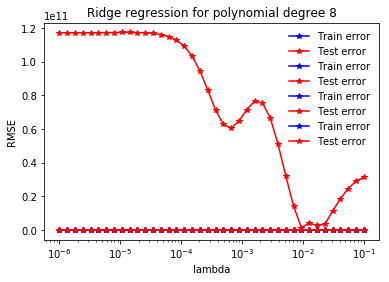

In [50]:

for i, model in enumerate(models):
    print('************ Model {} ************* '.format(i+1))
    weights_no_nan, degree_no_nan, lambda_no_nan = test_ridge_regression(
        model['x_train'], model['y_train'], model['x_validation'], model['y_validation'], 
        degrees = np.linspace(1,11,11), lambdas=np.logspace(-6,-1, 40))

In [9]:
# Model 1:
# Best params for Ridge regression : degree =  9 , lambda =  0.000206913808111 , accuracy =  0.842567272273
# Best params for Ridge regression : degree =  9 , lambda =  0.00016681005372 , accuracy =  0.842804520197
# Feat Aug
# Best params for Ridge regression : degree =  8 , lambda =  1.91448197617e-05 , accuracy =  0.842417431479
# Model 2:
# Best params for Ridge regression : degree =  7 , lambda =  0.000615848211066 , accuracy =  0.779464300147
# Best params for Ridge regression : degree =  7 , lambda =  0.000661474064123 , accuracy =  0.779415805894
# Feat Aug
# Best params for Ridge regression : degree =  7 , lambda =  0.000661474064123 , accuracy =  0.778866204355
# Model 3:
# Best params for Ridge regression : degree =  9 , lambda =  0.000615848211066 , accuracy =  0.803870007442
# Best params for Ridge regression : degree =  9 , lambda =  0.000272833337649 , accuracy =  0.805284048623
# Feat Aug
# Best params for Ridge regression : degree =  9 , lambda =  0.000492388263171 , accuracy =  0.803572314562
# Model 4:
# Best params for Ridge regression : degree =  8 , lambda =  0.000615848211066 , accuracy =  0.789595310563
# Best params for Ridge regression : degree =  8 , lambda =  0.000366524123708 , accuracy =  0.790046218014
# Feat Aug
# Best params for Ridge regression : degree =  8 , lambda =  0.000661474064123 , accuracy =  0.786438958404

acc = np.array([0.842567272273, 0.779464300147, 0.805284048623, 0.790046218014])
print('Accuracy = {}'.format(acc.dot(repart_jet)))

Accuracy = 0.8106238605375409


In [15]:
from scripts.implementations import build_poly, least_squares, accuracy
from scripts.proj1_helpers import predict_labels

y_pred = np.zeros(len(y_test))
best_degrees = [9, 7, 9, 8]
best_lambda = [0.000206913808111, 0.000615848211066, 0.000272833337649, 0.000366524123708]
for i, model in enumerate(models):
    
    phi_train = lib.build_poly(model['x_train'], best_degrees[i])
    phi_test = lib.build_poly(model['x_test'], best_degrees[i])
    mse_tr, weights = lib.ridge_regression(model['y_train'], phi_train, best_lambda[i])
    y_pred[model['id_test']] = predict_labels(weights, phi_test)
    print(mse_tr)
    print(len(y_pred), len(model['id_test']))

0.233524097725
568238 568238
0.312458238802
568238 568238
0.276830947233
568238 568238
0.285257530654
568238 568238


In [17]:
from scripts.proj1_helpers import create_csv_submission

create_csv_submission(ids_test, y_pred, 'submission.csv')
print('Results saved ...')

Results saved ...
